In [1]:
import csv

import numpy as np

from scipy.linalg import eigh

import networkx as nx
import community

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

In [2]:
# Redditors who commented in /r/X also commented in /r/Y
# An undirected network of subreddits connected by user activity

# Example: Suppose a user comments sufficiently on /r/politics and on /r/news.
# Then the edge between /r/politics and /r/news will be incremented.
# Hence the total edge weight between these subreddits is the number of users active on both subreddits.
# If this user also posts on /r/cats, then all edges in the triangle between these subreddits will be incremented.

# Idea originally from: https://www.curiousgnu.com/reddit-comments 
# Data download link and the below query from: http://minimaxir.com/2016/05/reddit-graph/

# Details: the query performs a self-join on a table of user-subreddit pairs (each user counts equally).
# A user-subreddit pair arises when a user comments on at least 5 threads of a subreddit.

"""
SELECT a.l_subreddit as Source, b.l_subreddit as Target, COUNT(*) as Weight
FROM 
(
  SELECT author, LOWER(subreddit) as l_subreddit, COUNT(DISTINCT(link_id)) as unique_threads
  FROM [pushshift:rt_reddit.comments]
  GROUP BY author, l_subreddit
  HAVING unique_threads >= 5
) a 
JOIN 
(
  SELECT author, LOWER(subreddit) as l_subreddit, COUNT(DISTINCT(link_id)) as unique_threads
  FROM [pushshift:rt_reddit.comments]
  GROUP BY author, l_subreddit
  HAVING unique_threads >= 5
) b 
ON a.author = b.author

GROUP BY Source, Target
HAVING Source < Target AND Weight >= 200
ORDER BY Weight DESC
"""

# Weighted adjacency dictionary per node
node_dictionary = {}

# Track statistics of weights, which represent the number of users that comment on both subreddits
all_weights = []

### HYPER PARAMETER ###
# Only retain links with more than minimum_weight links between subreddits
# 200 is the minimum in the dataset (already pruned)
minimum_weight = 200
    
# Ban reddits that have nothing specific about them -- will allow for a richer community structure
banned = ['askreddit', 'pics', 'funny', 'videos', 'gifs', 'todayilearned']

with open('reddit_edges.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for rowDict in reader:
        weight = int(rowDict['Weight'])
        if weight > minimum_weight:
            all_weights.append(weight)
            
            source = rowDict['Source']
            target = rowDict['Target']
            
            if source in banned or target in banned:
                continue
    
            if source not in node_dictionary:
                node_dictionary[source] = {}
            if target not in node_dictionary:
                node_dictionary[target] = {}
                
            node_dictionary[source][target] = weight
            node_dictionary[target][source] = weight

In [3]:
nodes = list(node_dictionary.keys())
num_nodes = len(nodes)
print(num_nodes)

node_names = {}
node_numbers = {}

for node_number, node_name in enumerate(sorted(nodes)):
    node_numbers[node_name] = node_number
    node_names[node_number] = node_name

870


In [4]:
# Distribution of weights
# There are extreme outliers on the far end
print('Min', np.min(all_weights))
print('10%', np.percentile(all_weights, 10))
print('25%', np.percentile(all_weights, 25))
print('50%', np.percentile(all_weights, 50))
print('Mean', np.mean(all_weights).round(1))
print('75%', np.percentile(all_weights, 75))
print('90%', np.percentile(all_weights, 90))    
print('99%', np.percentile(all_weights, 99))    
print('Max', np.max(all_weights))

Min 201
10% 219.0
25% 253.0
50% 360.5
Mean 814.4
75% 650.0
90% 1345.0
99% 9468.81
Max 47447


In [5]:
# Distribution of edges
# A very large number of subreddits are nearly isolated and should be removed
all_edges = [len(v) for v in node_dictionary.values()]

print('Min', np.min(all_edges))
print('10%', np.percentile(all_edges, 10))
print('25%', np.percentile(all_edges, 25))
print('50%', np.percentile(all_edges, 50))
print('Mean', np.mean(all_edges).round(1))
print('75%', np.percentile(all_edges, 75))
print('90%', np.percentile(all_edges, 90))    
print('99%', np.percentile(all_edges, 99))    
print('Max', np.max(all_edges))

Min 1
10% 1.0
25% 1.0
50% 2.0
Mean 11.3
75% 8.0
90% 27.1
99% 143.3
Max 279


In [6]:
# To remove
singles = [k for k, v in node_dictionary.items() if len(v) == 1]
# Some samples
print(singles[:20])

['liverpoolfc', 'fifa', 'competitivehs', 'denverbroncos', 'teamsolomid', 'ssbm', 'kappa', 'lakers', 'asktrp', 'vaping', 'coys', 'chelseafc', 'dndnext', 'nexus6p', 'mechmarket', 'bjj', 'detroitredwings', 'customhearthstone', 'hcteams', 'kohi']


In [7]:
# A look at the outliers
sorted_node_names = sorted(node_dictionary.keys(), key=lambda x: np.sum(list(node_dictionary[x].values())), reverse=True)

# We should treat these very popular subreddits that have too many connections to be meaningful
for node_name in sorted_node_names[:25]:
    adjacency_dict = node_dictionary[node_name]
    num_connections = len(adjacency_dict)
    total_shared_links = np.sum(list(adjacency_dict.values()))
    
    print(node_name)
    print('Links {}'.format(num_connections),
          'Overlap: {}k'.format(round(total_shared_links / 1000.0, 1)))
    print('')

worldnews
Links 279 Overlap: 275.0k

news
Links 246 Overlap: 257.4k

politics
Links 260 Overlap: 256.7k

gaming
Links 267 Overlap: 242.3k

movies
Links 254 Overlap: 229.2k

adviceanimals
Links 217 Overlap: 197.0k

wtf
Links 218 Overlap: 188.9k

showerthoughts
Links 164 Overlap: 143.2k

pcmasterrace
Links 172 Overlap: 109.9k

sandersforpresident
Links 120 Overlap: 102.9k

the_donald
Links 119 Overlap: 99.1k

technology
Links 134 Overlap: 94.0k

mildlyinteresting
Links 110 Overlap: 91.3k

nfl
Links 131 Overlap: 88.4k

aww
Links 110 Overlap: 86.5k

explainlikeimfive
Links 111 Overlap: 79.5k

nba
Links 105 Overlap: 71.0k

television
Links 95 Overlap: 65.2k

leagueoflegends
Links 96 Overlap: 62.5k

games
Links 108 Overlap: 61.8k

nottheonion
Links 77 Overlap: 59.6k

blackpeopletwitter
Links 90 Overlap: 56.5k

soccer
Links 80 Overlap: 49.3k

tumblrinaction
Links 84 Overlap: 42.8k

hockey
Links 81 Overlap: 40.1k



In [8]:
# To capture the most meaningful interactions, 
# sparsify the graph to contain only the top 10 most important edges per node in a directed sense
# In an undirected sense, a node may still have more than 10 edges, 
# but the edge will be a top 10 for one of the nodes

### HYPER PARAMETER ###
top_links = 10 # 5

# Weighted edge triplets (directed)
edges = {}

for source, adjacency_dict in node_dictionary.items():
    # Exclude nodes with only a single connection
    if source in singles:
        continue
    
    edges[source] = {}
    
    # For normalization
    max_weight = np.max(list(adjacency_dict.values()))
    
    for target in sorted(adjacency_dict, key=lambda x: adjacency_dict[x], reverse=True)[: top_links]:
        # Also exclude target nodes with only a single connection
        if target in singles:
            continue
            
        weight = adjacency_dict[target]
        normalized_weight = 1.0 * weight / max_weight
        
        # Add weighted edge to edge list
        edges[source][target] = normalized_weight

In [9]:
# A new look at the outliers

for node_name in sorted_node_names[:25]:
    adjacency_dict = edges[node_name]
    
    print(node_name)
    for k, v in adjacency_dict.items():
        print(k, v.round(3))
    print('')

worldnews
news 1.0
politics 0.733
gaming 0.464
movies 0.462
adviceanimals 0.431
wtf 0.427
technology 0.336
showerthoughts 0.327
the_donald 0.287
sandersforpresident 0.264

news
worldnews 1.0
politics 0.766
movies 0.474
adviceanimals 0.465
gaming 0.433
wtf 0.399
showerthoughts 0.347
technology 0.3
sandersforpresident 0.277
the_donald 0.259

politics
sandersforpresident 1.0
news 0.9
worldnews 0.862
the_donald 0.642
adviceanimals 0.627
movies 0.487
wtf 0.431
gaming 0.373
technology 0.318
politicaldiscussion 0.312

gaming
movies 1.0
worldnews 0.937
adviceanimals 0.896
news 0.874
wtf 0.838
showerthoughts 0.691
pcmasterrace 0.656
politics 0.642
aww 0.489
mildlyinteresting 0.459

movies
gaming 1.0
news 0.956
worldnews 0.934
politics 0.837
adviceanimals 0.711
television 0.638
wtf 0.623
showerthoughts 0.543
aww 0.374
technology 0.357

adviceanimals
wtf 1.0
politics 0.963
news 0.84
gaming 0.801
worldnews 0.779
movies 0.636
the_donald 0.481
sandersforpresident 0.462
showerthoughts 0.413
aww 0.406

In [10]:
# A look at some reasonable nodes

for node_name in sorted_node_names[300:325]:
    if node_name in edges:
        adjacency_dict = edges[node_name]

        print(node_name)
        for k, v in adjacency_dict.items():
            print(k, v.round(3))
        print('')

military
worldnews 0.896
news 0.834
politics 0.656
wtf 0.602

syriancivilwar
worldnews 1.0
europe 0.413
politics 0.406
combatfootage 0.372

shitamericanssay
worldnews 1.0
unitedkingdom 0.564
europe 0.522
news 0.515
politics 0.51

lsd
drugs 1.0
trees 0.597
psychonaut 0.36
darknetmarkets 0.348

darknetmarkets
drugs 1.0
lsd 0.372

teslamotors
spacex 1.0
politics 0.955
worldnews 0.875
news 0.744
technology 0.651

spacex
teslamotors 1.0
space 0.91
worldnews 0.869
politics 0.715
kerbalspaceprogram 0.696

codzombies
blackops3 1.0
gaming 0.217

onepiece
leagueoflegends 1.0
anime 0.9
movies 0.698
gaming 0.689
pokemon 0.616

batman
movies 1.0
dccomics 0.586
gaming 0.421
dc_cinematic 0.417

guildwars2
leagueoflegends 1.0
blackdesertonline 0.866
gaming 0.824
overwatch 0.745
worldnews 0.729

casualiama
showerthoughts 1.0
wtf 0.923
adviceanimals 0.909
worldnews 0.905
news 0.85

torontoraptors
nba 1.0
torontobluejays 0.262

clevelandcavs
nba 1.0
browns 0.364
nfl 0.332

nfl_draft
nfl 1.0
nba 0.264

de

In [11]:
E = {}

for source in edges:
    for target, weight in edges[source].items():
    
        # Back to undirected
        pair = (source, target) if source > target else (target, source)
    
        if pair not in E:
            E[pair] = weight
        else:
            # Take the geometric mean of the two
            E[pair] = np.sqrt(E[pair] * weight)

num_edges = len(E)
print(num_edges)

2634


In [12]:
# Flatten E and encode as integers
flat_E = []

for pair, weight in E.items():
    node_1 = node_numbers[pair[0]]
    node_2 = node_numbers[pair[1]]
    
    flat_E.append([node_1, node_2, weight])

In [35]:
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_weighted_edges_from(flat_E)

# Optional: only take the large connected component
M = max(nx.connected_component_subgraphs(G), key=len)

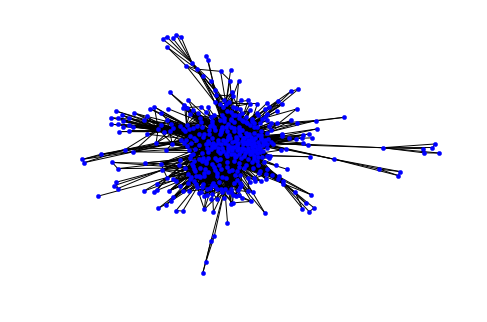

In [45]:
nx.draw_spring(M, weight='None', node_size=20, linewidths=0.25, node_color='blue')

In [30]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 870
Number of edges: 2634
Average degree:   6.0552


Community 1 (119 nodes)

gaming, pcmasterrace, leagueoflegends, games, overwatch, globaloffensive, hearthstone, darksouls3, thedivision, ps4, dota2, pcgaming, wow, pokemon, xboxone, anime, destinythegame, magictcg, rocketleague, buildapc, heroesofthestorm, oculus, blackops3, smashbros, vive, h3h3productions, nintendo, summonerschool, undertale, tf2

Breakable by removing 1 node(s)
Triangleness 0.19
Cliqueyness 0.72


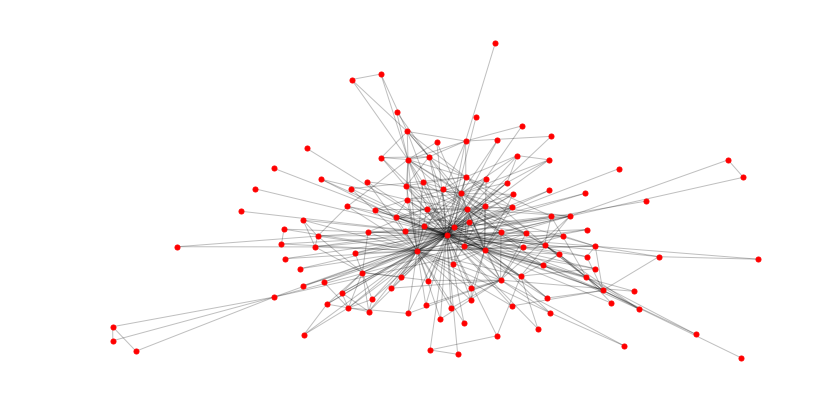


Community 2 (46 nodes)

nfl, nba, blackpeopletwitter, soccer, hockey, hiphopheads, baseball, squaredcircle, canada, mma, cfb, collegebasketball, trashy, streetwear, sneakers, formula1, kanye, toronto, mls, malefashionadvice, teenagers, patriots, gunners, torontobluejays, reddevils, supremeclothing, fashionreps, repsneakers, eagles, warriors

Breakable by removing 1 node(s)
Triangleness 0.31
Cliqueyness 0.63


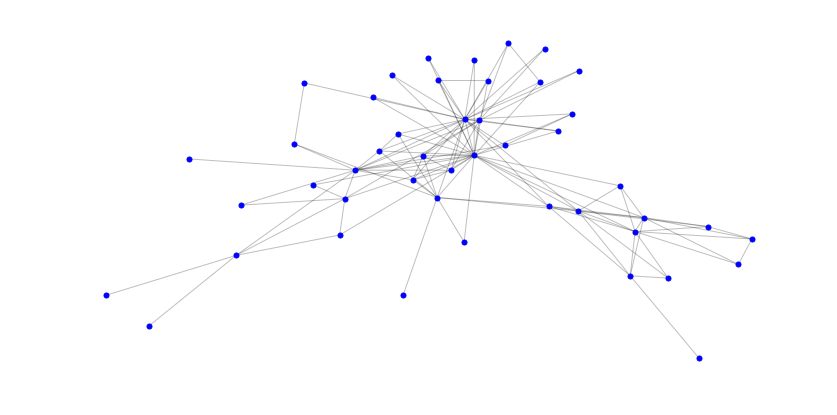


Community 3 (79 nodes)

news, politics, sandersforpresident, the_donald, technology, atheism, android, politicaldiscussion, 4chan, subredditdrama, apple, hillaryclinton, conspiracy, guns, conservative, programming, changemyview, legaladvice, sysadmin, enoughsandersspam, linux, libertarian, asktrumpsupporters, truereddit, programmerhumor, startrek, circlejerk, theredpill, bodybuilding, seattle

Breakable by removing 1 node(s)
Triangleness 0.17
Cliqueyness 0.67


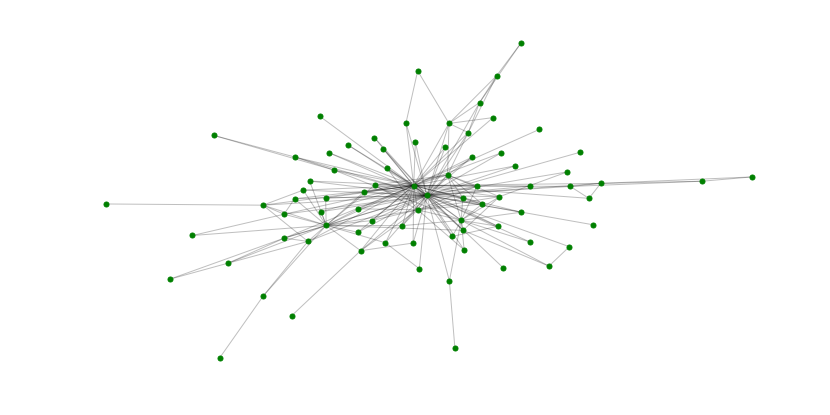


Community 4 (63 nodes)

adviceanimals, wtf, tumblrinaction, cringeanarchy, cringepics, fo4, fallout, cringe, me_irl, cars, kotakuinaction, iamverysmart, thathappened, justneckbeardthings, justrolledintotheshop, dnd, motorcycles, australia, publicfreakout, quityourbullshit, talesfromtechsupport, mensrights, roadcam, niceguys, forwardsfromgrandma, youtubehaiku, skyrim, cooking, shitty_car_mods, eve

Breakable by removing 1 node(s)
Triangleness 0.17
Cliqueyness 0.64


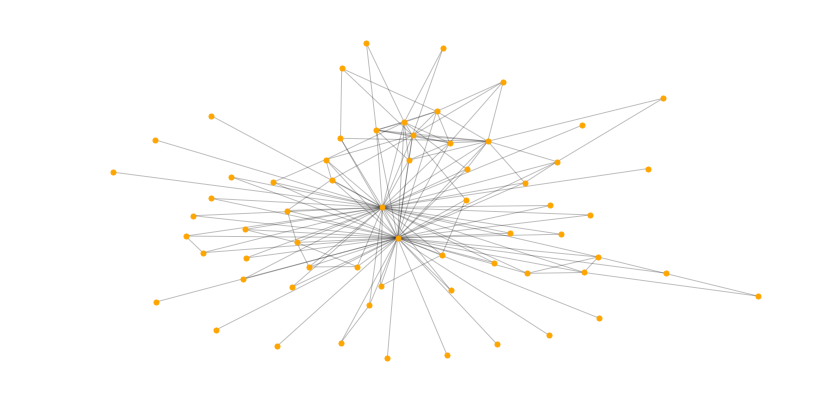


Community 5 (61 nodes)

movies, showerthoughts, mildlyinteresting, aww, explainlikeimfive, nottheonion, tifu, music, lifeprotips, jokes, interestingasfuck, science, futurology, personalfinance, iama, oldschoolcool, food, sports, woahdude, imgoingtohellforthis, books, dataisbeautiful, reactiongifs, roastme, facepalm, documentaries, creepy, outoftheloop, unexpected, mildlyinfuriating

Breakable by removing 1 node(s)
Triangleness 0.24
Cliqueyness 0.83


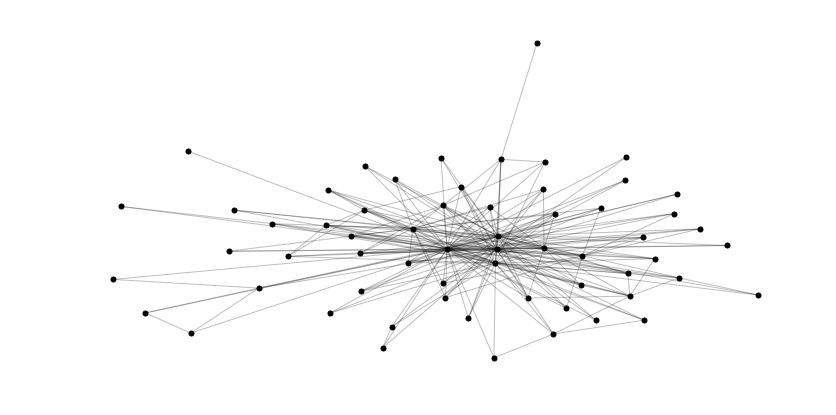

In [14]:
colors = ['red', 'blue', 'green', 'orange', 'black', 'purple']

# Pre-compute the best partition

### HYPER PARAMETER ###

# Ignore edge weights since they can overfit and have noise
# Lower resoluition communities seem more interesting (super subjective)
partition = community.best_partition(G, resolution=0.9, weight='None')

communities = set(partition.values())

biggest_community = None
biggest_size = 0

i = 0
for community_number in communities:
    community_nodes = [node for node in partition.keys() if partition[node] == community_number]
    community_size = len(community_nodes)
    
    if community_size > 30:         
        # For labeling
        community_names = {node: node_names[node] for node in community_nodes}
        
        # For understanding
        top_names = []
        for node_name in sorted_node_names:
            if node_name in community_names.values():
                top_names.append(node_name)
                if len(top_names) == 30:
                    break

        H = G.subgraph(community_nodes)
        # Gaming and sports communities are actually logical and big
        if community_size > biggest_size and 'leagueoflegends' not in top_names and 'warriors' not in top_names:
            biggest_community = H
            biggest_size = community_size
        
        pos = nx.spring_layout(H, weight=None)
        
        plt.figure(figsize=(14, 7))
        nx.draw_networkx_nodes(H, pos, node_size = 25, node_color = colors[i % len(colors)])
        nx.draw_networkx_edges(H, pos, alpha=0.25)
        
        i += 1
        print('Community {} ({} nodes)'.format(i, community_size))
        print('')
        print(', '.join(top_names))
        print('')
        # For assessing trivial communities
        print('Breakable by removing {} node(s)'.format(nx.node_connectivity(H)))
        print('Triangleness', round(nx.transitivity(H), 2))
        print('Cliqueyness', round(nx.average_clustering(H), 2))

        plt.axis('off')
        plt.show()
        print('')

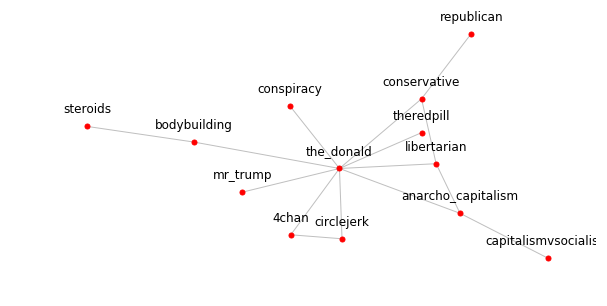

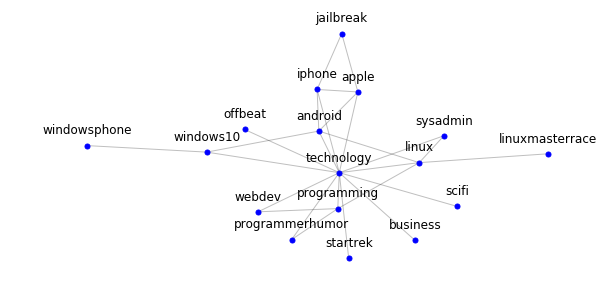

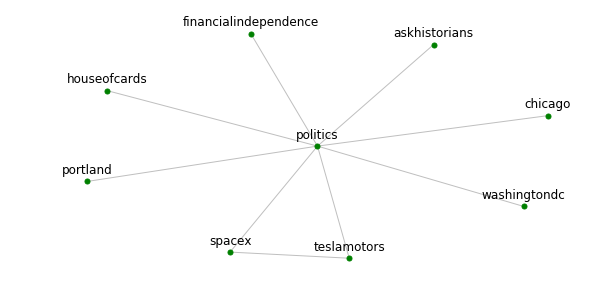

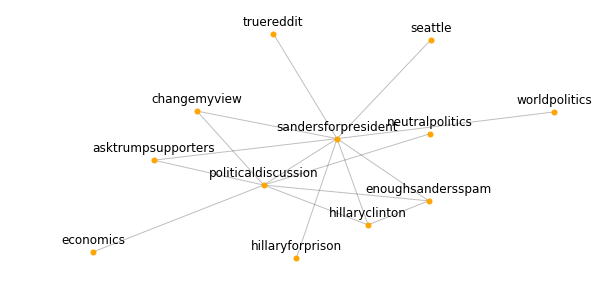

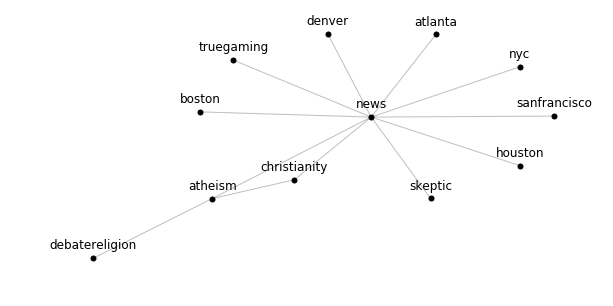

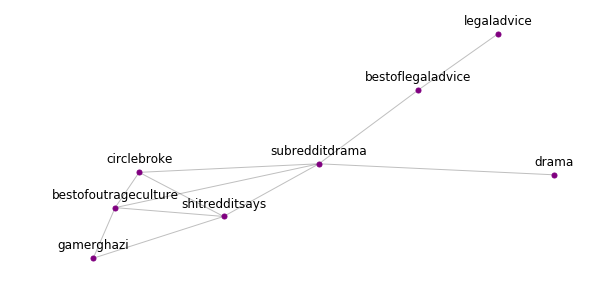

In [24]:
# Further disect the massive community -- seems like a crap hole of Reddit

sub_partition = community.best_partition(biggest_community, resolution=0.9, weight='None')

sub_communities = set(sub_partition.values())

i = 0
for community_number in sub_communities:
    community_nodes = [node for node in sub_partition.keys() if sub_partition[node] == community_number]
    community_size = len(community_nodes)
    
    if community_size > 5:         
        # For labeling
        community_names = {node: node_names[node] for node in community_nodes}
        
        H = G.subgraph(community_nodes)
        
        pos = nx.spring_layout(H, weight=None)
        
        plt.figure(figsize=(10, 5))
        nx.draw_networkx_nodes(H, pos, node_size = 25, node_color = colors[i % len(colors)])
        nx.draw_networkx_edges(H, pos, alpha=0.25)
        
        offset_pos = {k: np.array(v) + (0.0, 0.1) for k, v in pos.items()}
        nx.draw_networkx_labels(H, offset_pos, labels=community_names, font_size=12)

        i += 1
        plt.axis('off')
        plt.show()
        print('')

# 3D Spectral Embedding -- Not so successful

Community 1 (119 nodes)



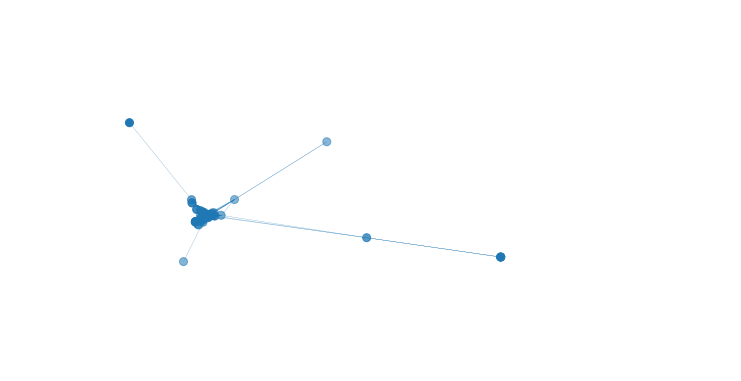

Community 2 (46 nodes)



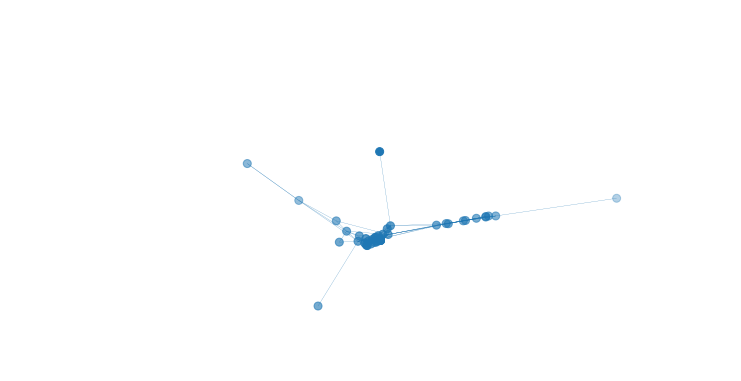

Community 3 (79 nodes)



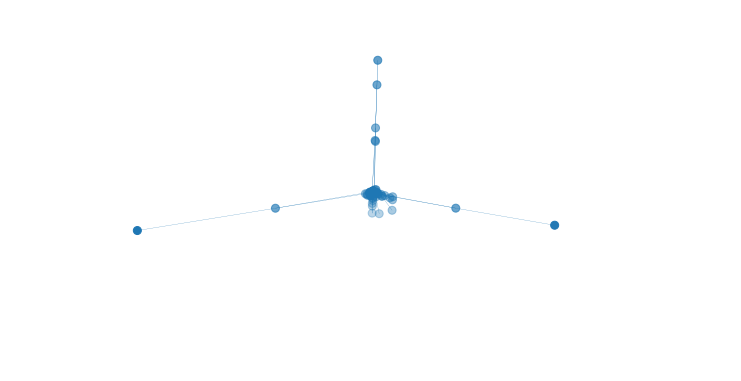

Community 4 (63 nodes)



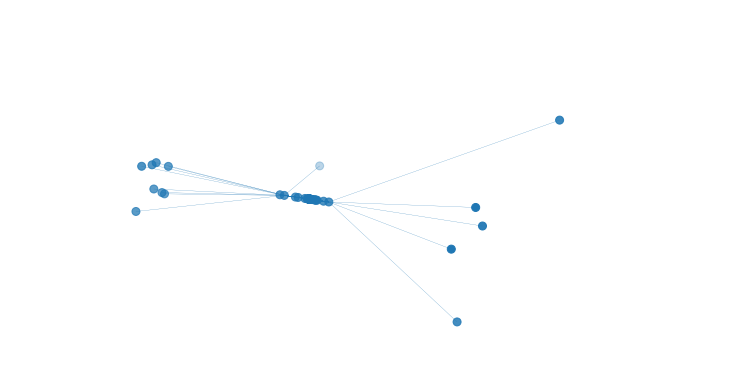

Community 5 (61 nodes)



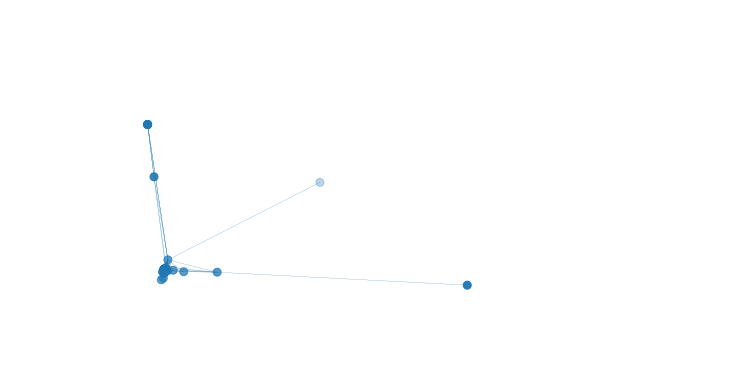

In [16]:
i = 0
for community_number in communities:
    community_nodes = [node for node in partition.keys() if partition[node] == community_number]
    community_size = len(community_nodes)

    if community_size > 30:
        H = G.subgraph(community_nodes)

        community_node_to_int = {node: node_count for node_count, node in enumerate(H.nodes())}
        community_int_to_node = {node_count: node for node_count, node in enumerate(H.nodes())}

        # Compute the Laplacian
        L = np.zeros([community_size, community_size])

        for edge in H.edges():
            # Map to ordered ints
            s = community_node_to_int[edge[0]]
            t = community_node_to_int[edge[1]]

            # Symmetry
            L[s, t] = 1.0    
            L[t, s] = 1.0

        for row_number in range(community_size):
            L[row_number, row_number] = -1.0 * L[row_number].sum()

        # Laplacian matrices are real and symmetric, so we can use eigh, 
        # the variation on eig specialized for Hermetian matrices.

        # w = eigenvalues, v = eigenvectors
        w, v = eigh(L)

        fig = plt.figure(figsize=(10, 5))
        ax = Axes3D(fig)

        x = v[:, -2] 
        y = v[:, -3]
        z = v[:, -4]
        positions = list(zip(x, y, z))

        ax.scatter(x, y, z, marker='o', s = 64)  

        segments = []
        for edge in H.edges():
            # Map to ordered ints
            s = community_node_to_int[edge[0]]
            t = community_node_to_int[edge[1]]

            segments.append([positions[s], positions[t]])

        edge_col = Line3DCollection(segments, lw=0.2)
        ax.add_collection3d(edge_col)

        ax.set_axis_off()
    
        i += 1
        print('Community {} ({} nodes)'.format(i, community_size))
        print('')

        plt.show()

# 3D Spring Layout -- Better

Community 1 (119 nodes)



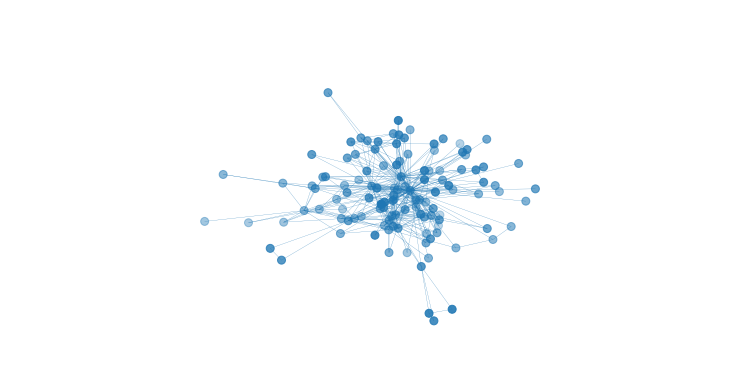

Community 2 (46 nodes)



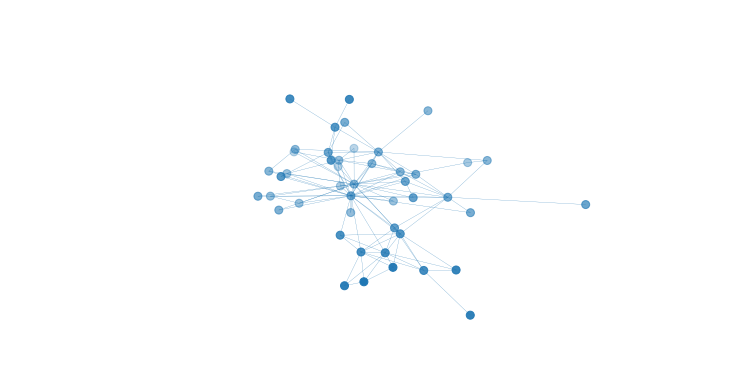

Community 3 (79 nodes)



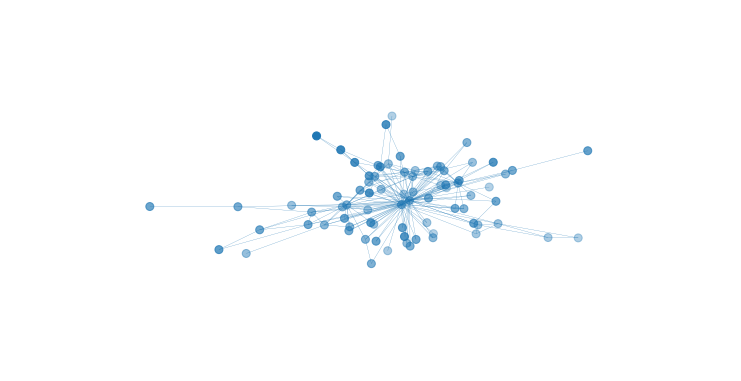

Community 4 (63 nodes)



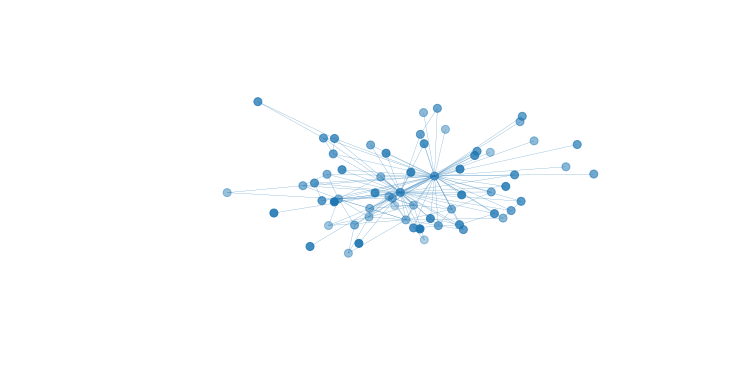

Community 5 (61 nodes)



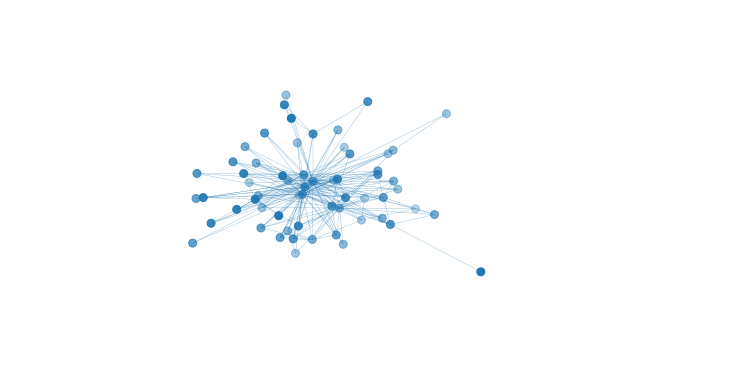

In [17]:
i = 0
for community_number in communities:
    community_nodes = [node for node in partition.keys() if partition[node] == community_number]
    community_size = len(community_nodes)

    if community_size > 30:
        H = G.subgraph(community_nodes)

        community_node_to_int = {node: node_count for node_count, node in enumerate(H.nodes())}
        community_int_to_node = {node_count: node for node_count, node in enumerate(H.nodes())}

        pos = nx.spring_layout(H, weight=None, dim=3)

        fig = plt.figure(figsize=(10, 5))
        ax = Axes3D(fig)
        
        # Map the position dictionary from nx into ordered lists, based on the original order of H.nodes()
        x = [pos[node][0] for node in H.nodes()]
        y = [pos[node][1] for node in H.nodes()]
        z = [pos[node][2] for node in H.nodes()]
        positions = list(zip(x, y, z))

        ax.scatter(x, y, z, marker='o', s = 64)  

        segments = []
        for edge in H.edges():
            # Map to ordered ints
            s = community_node_to_int[edge[0]]
            t = community_node_to_int[edge[1]]

            segments.append([positions[s], positions[t]])

        edge_col = Line3DCollection(segments, lw=0.2)
        ax.add_collection3d(edge_col)

        ax.set_axis_off()
    
        i += 1
        print('Community {} ({} nodes)'.format(i, community_size))
        print('')

        plt.show()

# Output

In [18]:
save = False

"""
Per each community:
P  #P by 3 list of vertex positions
E  #E by 2 list of edge indices into P
L  #P by 3 list of label positions, #P list of label strings
"""

i = 0
for community_number in communities:
    community_nodes = [node for node in partition.keys() if partition[node] == community_number]
    community_size = len(community_nodes)

    if community_size > 30:
        H = G.subgraph(community_nodes)

        # Dictionary of positions
        positions_3d = nx.spring_layout(H, weight=None, dim=3)
        
        # Convert pos into lists, in the same order as H.nodes()
        x = [positions_3d[node][0] for node in H.nodes()]
        y = [positions_3d[node][1] for node in H.nodes()]
        z = [positions_3d[node][2] for node in H.nodes()]
        Positions = list(zip(x, y, z))
        
        # Save the order of the nodes in H.nodes()
        community_node_to_int = {node: node_count for node_count, node in enumerate(H.nodes())}
        
        Edges = []
        for edge in H.edges():
            # Map the original nodes in H to ordered integers 
            # which correspond to the indexes into Positions
            s = community_node_to_int[edge[0]]
            t = community_node_to_int[edge[1]]
            Edges.append([s, t])
            
        # Reverse the mapping from integer back to original node
        community_int_to_node = {node_count: node for node_count, node in enumerate(H.nodes())}

        Labels = []
        for node_number in range(len(Positions)): 
            original_node = community_int_to_node[node_number]
            Labels.append(node_names[original_node])

        i += 1
        
#         if save:
#             with open('./RedditCommunities/{}/P.txt'.format(i), 'w') as file_handler:
#                 for item in Positions:
#                     line = []
#                     for float_value in item:
#                         line.append("{}".format(float_value.round(5)))
#                     line = ' '.join(line)
#                     file_handler.write("{}\n".format(line))
#             with open('./RedditCommunities/{}/E.txt'.format(i), 'w') as file_handler:
#                 for item in Edges:
#                     line = []
#                     for integer_value in item:
#                         line.append(str(integer_value))
#                     line = ' '.join(line)
#                     file_handler.write("{}\n".format(line))
#             with open('./RedditCommunities/{}/L.txt'.format(i), 'w') as file_handler:
#                 for item in Labels:
#                     file_handler.write("{}\n".format(item))